In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [8]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

print(predictors.shape,label.shape)

--2021-03-05 16:20:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-03-05 16:20:00 (161 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]

(15462, 10) (15462, 3211)


In [9]:
model = Sequential()
model.add(Embedding(total_words,100,input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(200, return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200)))
model.add(Dense(total_words, activation='relu', kernel_regularizer=regularizers.l2()))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 400)           481600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 400)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 400)               961600    
_________________________________________________________________
dense_2 (Dense)              (None, 3211)              1287611   
_________________________________________________________________
dense_3 (Dense)              (None, 3211)              10313732  
Total params: 13,365,643
Trainable params: 13,365,643
Non-trainable params: 0
__________________________________________

In [10]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 40s 13ms/step - loss: 7.8354 - accuracy: 0.0214
Epoch 2/100
484/484 [==============================] - 6s 13ms/step - loss: 6.5101 - accuracy: 0.0232
Epoch 3/100
484/484 [==============================] - 6s 13ms/step - loss: 6.3813 - accuracy: 0.0256
Epoch 4/100
484/484 [==============================] - 6s 13ms/step - loss: 6.2516 - accuracy: 0.0319
Epoch 5/100
484/484 [==============================] - 6s 13ms/step - loss: 6.1466 - accuracy: 0.0362
Epoch 6/100
484/484 [==============================] - 6s 13ms/step - loss: 6.0287 - accuracy: 0.0423
Epoch 7/100
484/484 [==============================] - 6s 13ms/step - loss: 5.8830 - accuracy: 0.0464
Epoch 8/100
484/484 [==============================] - 6s 13ms/step - loss: 5.7572 - accuracy: 0.0578
Epoch 9/100
484/484 [==============================] - 6s 13ms/step - loss: 5.6217 - accuracy: 0.0614
Epoch 10/100
484/484 [==============================] - 6s 13ms/step - loss: 5.49

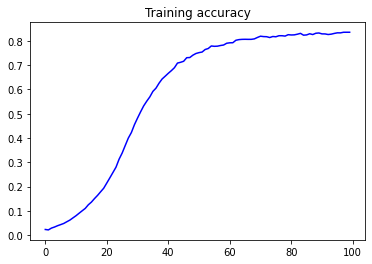

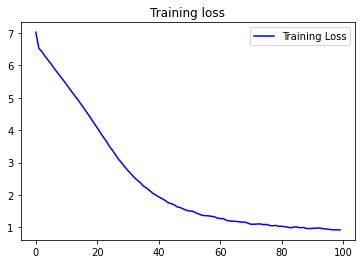

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [12]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope and grace where found her song in truth doth plea drinks it ill did not brought to view no woe in true friend grow mad by woe bars her perceived torn amazeth survey survey survey woe ' had seen store quite blot the inward days by hours to happy ill eye doth i deem'd green my wit repair prove before thee be such too dumb so dwell in told to gone on me go must be near dumb doth gone anew to till such happy ill in my friend ill well must know you live so strong such substance grow
